In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

Rows in merged training set: 590540
Columns in merged training set: 434


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Missing percentages per column:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_03            88.768923
id_04            88.768923
D6               87.606767
id_33            87.589494
id_10            87.312290
id_09            87.312290
D9               87.312290
D8               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V142             86.123717
V158             86.123717
V140             86.123717
V162             86.123717
V141             86.123717
V161             86.123717
V157             86.123717
V146             86.123717
V156             86.123

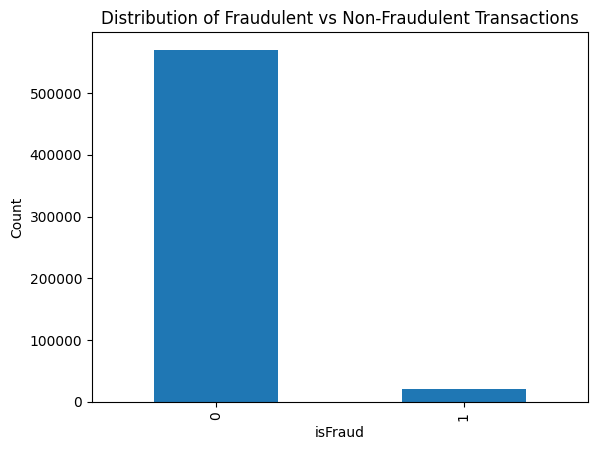

In [4]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [5]:
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [6]:
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


              m_flag_dist2   isFraud
m_flag_dist2      1.000000 -0.091096
isFraud          -0.091096  1.000000
           m_flag_D7   isFraud
m_flag_D7   1.000000 -0.164478
isFraud    -0.164478  1.000000
              m_flag_id_07   isFraud
m_flag_id_07      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_08   isFraud
m_flag_id_08      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_18   isFraud
m_flag_id_18      1.000000 -0.074815
isFraud          -0.074815  1.000000
              m_flag_id_21  isFraud
m_flag_id_21       1.00000 -0.02431
isFraud           -0.02431  1.00000
              m_flag_id_22   isFraud
m_flag_id_22      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_23   isFraud
m_flag_id_23      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_24   isFraud
m_flag_id_24      1.000000 -0.024345
isFraud          -0.024345  1.000000
              m_flag_i

In [7]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

ProductCD 5 {'C', 'R', 'S', 'H', 'W'}
card4 5 {'discover', 'mastercard', 'visa', 'american express', nan}
card6 5 {'charge card', 'credit', 'debit or credit', 'debit', nan}
P_emaildomain 60 {'gmx.de', 'ymail.com', 'yahoo.com.mx', 'roadrunner.com', 'windstream.net', 'aim.com', 'mail.com', 'yahoo.com', 'hotmail.com', 'mac.com', 'rocketmail.com', 'hotmail.co.uk', 'anonymous.com', 'me.com', 'yahoo.es', nan, 'earthlink.net', 'frontiernet.net', 'hotmail.de', 'verizon.net', 'charter.net', 'gmail.com', 'cox.net', 'frontier.com', 'gmail', 'cableone.net', 'embarqmail.com', 'sc.rr.com', 'outlook.com', 'cfl.rr.com', 'q.com', 'comcast.net', 'centurylink.net', 'servicios-ta.com', 'protonmail.com', 'live.fr', 'yahoo.co.jp', 'att.net', 'outlook.es', 'live.com', 'netzero.com', 'yahoo.fr', 'optonline.net', 'web.de', 'hotmail.es', 'sbcglobal.net', 'aol.com', 'ptd.net', 'suddenlink.net', 'netzero.net', 'twc.com', 'yahoo.de', 'live.com.mx', 'icloud.com', 'juno.com', 'bellsouth.net', 'yahoo.co.uk', 'prodigy

### Find truly categorical values

In [8]:
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [9]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if unique_vals < unique_threshold and col != "isFraud":
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

Candidate categorical features (numeric columns with few unique values):
V1: 2 unique values
V2: 9 unique values
V3: 10 unique values
V4: 7 unique values
V5: 7 unique values
V6: 10 unique values
V7: 10 unique values
V8: 9 unique values
V9: 9 unique values
V10: 5 unique values
V11: 6 unique values
V12: 4 unique values
V13: 7 unique values
V14: 2 unique values
V15: 8 unique values
V16: 15 unique values
V17: 16 unique values
V18: 16 unique values
V19: 8 unique values
V20: 15 unique values
V21: 6 unique values
V22: 9 unique values
V23: 14 unique values
V24: 14 unique values
V25: 7 unique values
V26: 13 unique values
V27: 4 unique values
V28: 4 unique values
V29: 6 unique values
V30: 8 unique values
V31: 8 unique values
V32: 15 unique values
V33: 7 unique values
V34: 13 unique values
V35: 4 unique values
V36: 6 unique values
V39: 16 unique values
V40: 18 unique values
V41: 2 unique values
V42: 9 unique values
V43: 9 unique values
V46: 7 unique values
V47: 9 unique values
V48: 6 unique value

### Imputing nulls

In [10]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys())))
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using median strategy; add indicator if desired
num_imputer = SimpleImputer(strategy='constant', fill_value=0)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

Total missing values after imputation: 0


### Data encoding

In [11]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

### Encoding categorical features

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
encoder_high = ce.WOEEncoder(cols=cat_cols)
X_train_encoded_cat = encoder_high.fit_transform(X_train[cat_cols], y_train)
X_test_encoded_cat = encoder_high.transform(X_test[cat_cols])

### Data normalization

In [14]:
scaler = StandardScaler()
X_train_scaled_num = scaler.fit_transform(X_train[num_cols])
X_test_scaled_num = scaler.transform(X_test[num_cols])

In [15]:
X_train_scaled = pd.DataFrame(np.hstack([X_train_encoded_cat.values, X_train_scaled_num]), columns=cat_cols + num_cols)
X_test_scaled = pd.DataFrame(np.hstack([X_test_encoded_cat.values, X_test_scaled_num]), columns=cat_cols + num_cols)

In [16]:
print("Encoded training set shape:", X_train_scaled.shape)
print("Encoded test set shape:", X_test_scaled.shape)

Encoded training set shape: (472432, 433)
Encoded test set shape: (118108, 433)


In [17]:
X_train_scaled.head()

,V17,V35,M8,V247,V117,V2,V52,M4,V26,id_31,V22,V71,V13,V240,V288,V260,V8,id_16,V50,V58,V16,M3,V9,id_04,V30,V33,M9,V122,V82,V195,V65,V174,V43,V42,V223,V125,V68,V118,V74,DeviceInfo,V12,id_18,V79,V48,V302,V108,id_34,V141,M5,V251,V24,V89,V60,V57,id_38,V6,V72,V20,V25,V93,V55,V34,id_23,V15,V107,P_emaildomain,id_32,V83,V11,V94,V300,V301,V69,V21,V75,V3,id_36,V327,V88,V90,id_24,M2,V40,V305,V92,V49,V46,V64,V110,V32,id_30,V62,V286,V85,V7,V142,V19,V67,V197,V98,V153,V325,card6,V66,V76,ProductCD,R_emaildomain,DeviceType,V4,V39,M6,V73,V115,V124,V119,V10,id_35,id_29,V41,V111,V241,V14,V47,V36,V51,V23,card4,V184,V29,V116,M1,V54,V123,V63,V175,id_27,V1,V27,V61,V304,V328,V173,V91,V109,V114,id_37,id_15,V112,V121,V284,V59,id_12,V120,V70,M7,id_28,V5,V297,V18,V84,V104,V113,V53,V250,V154,V28,V31,V289,V194,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V37,V38,V44,V45,V56,V77,V78,V80,V81,V86,V87,V95,V96,V97,V99,V100,V101,V102,V103,V105,V106,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V176,V177,V178,V179,V180,V181,V182,V183,V185,V186,V187,V188,V189,V190,V191,V192,V193,V196,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V248,V249,V252,V253,V254,V255,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V290,V291,V292,V293,V294,V295,V296,V298,V299,V303,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V326,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_21,id_22,id_25,id_26,Screen_Width,Screen_Height
0,0.383795,0.028950,0.275416,0.702588,-0.009943,0.410700,0.028950,-0.653040,0.383795,-0.612598,0.383795,0.531234,0.383795,0.843236,-0.077195,0.708125,0.410700,1.187974,0.02895,0.531234,0.383795,0.423702,0.410700,1.174202,0.383795,0.383795,0.275416,-0.004764,0.325713,0.531945,0.531234,0.829283,0.02895,0.028950,0.836027,-0.086159,0.531234,-0.009934,0.531234,-1.080841,0.383795,-0.121683,0.325713,0.028950,0.827407,-0.033578,0.106197,0.174927,0.066966,0.610189,0.383795,0.325713,0.531234,0.531234,0.542538,0.410700,0.531234,0.383795,0.383795,0.325713,0.531234,0.383795,-0.012757,0.383795,-0.000195,-0.395075,-0.043298,0.325713,0.41070,0.325713,-0.026793,-0.036066,0.531234,0.383795,0.325713,0.410700,0.894744,0.216208,0.325713,0.325713,-0.01215,0.423702,0.028950,-0.000099,0.325713,0.028950,0.028950,0.531234,-0.034195,0.383795,-0.063873,0.531234,-0.005473,0.325713,0.410700,0.173348,0.383795,0.531234,0.553973,-0.038494,0.069703,0.237782,0.682454,0.531234,0.325713,0.090415,-0.169704,0.652664,0.410700,0.02895,0.737784,0.531234,-0.045227,-0.073621,-0.010113,0.41070,0.243019,1.161001,0.02895,-0.035588,0.843918,0.383795,0.028950,0.028950,0.028950,0.383795,-0.142730,0.719326,0.383795,-0.046097,0.423702,0.531234,-0.085018,0.531234,0.827610,-0.012757,0.410700,0.383795,0.531234,0.802900,0.190160,0.872048,0.325713,-0.033529,-0.043011,0.915791,1.165839,-0.03759,-0.004744,-0.060493,0.531234,0.893194,-0.004153,0.531234,0.275378,1.142724,0.410700,-0.017537,0.383795,0.325713,-0.024835,-0.036001,0.531234,0.644286,0.031686,0.383795,0.383795,-0.080630,0.553973,-1.378728,-0.145302,-0.759998,0.257853,-0.203484,-1.078432,0.042876,0.360192,-0.196545,-0.094803,-0.098434,-0.092693,-0.039137,-0.030306,-0.215803,-0.113225,-0.046189,-0.032914,-0.268532,-0.033820,-0.098328,-0.047102,-0.236331,-0.147581,3.269944,3.383160,-0.323817,-0.576067,-0.309651,-0.155767,-0.099152,6.159508,2.726051,-0.616023,

### Save data

In [18]:
X_train_scaled.to_csv("data/preprocessed_train.csv", index=False)
X_test_scaled.to_csv("data/preprocessed_test.csv", index=False)

In [ ]:
def run_genetic_algorithm(X_data, y_data):
    """
    Placeholder for GA. Return a subset of feature indices.
    """
    # TODO: Implement population, crossover, mutation, selection, etc.
    # For demonstration, return all features:
    return np.arange(X_data.shape[1])

best_features = run_genetic_algorithm(X_train, y_train)
X_train_ga = X_train.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]

In [ ]:
model = SVC(kernel="rbf")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Baseline model Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
def run_pso_for_hyperparams(X_data, y_data, model_class):
    """
    Placeholder for PSO. Return best hyperparams found.
    """
    # TODO: Swarm initialization, velocity updates, fitness evaluation, etc.
    return {"C": 1.0, "kernel": "rbf"}  # example

best_params = run_pso_for_hyperparams(X_train_ga, y_train, SVC)
model_pso = SVC(**best_params)
model_pso.fit(X_train_ga, y_train)
y_pred_pso = model_pso.predict(X_test_ga)
print("PSO-tuned model Accuracy:", accuracy_score(y_test, y_pred_pso))

In [ ]:
def run_aco_classification(X_data, y_data):
    """
    Placeholder for ACO. Return final classification model or rules.
    """
    # TODO: ACO logic with ants’ path optimization, pheromone updates, etc.
    # Here we simply return the same baseline model for demonstration:
    return SVC(kernel="rbf")

aco_model = run_aco_classification(X_train_ga, y_train)
aco_model.fit(X_train_ga, y_train)
y_pred_aco = aco_model.predict(X_test_ga)
print("ACO-based model Accuracy:", accuracy_score(y_test, y_pred_aco))